**Feature Selection Rationale**

The goal of feature selection is to choose variables that are likely to be good indicators of customer similarity. We want features that capture:

1. **Customer Demographics:** Basic information about the customer.
2. **Purchase Behavior:** How much, how often, and what they buy.
3. **Engagement/Recency:** How recently they have interacted with the platform.

Here's the rationale for each feature:

**Customer Features:**

*   **Region (One-Hot Encoded):**
    *   **Reasoning:** Customers from the same region might share similar preferences, cultural influences, or economic backgrounds, which could affect their purchasing behavior. One-hot encoding allows us to use this categorical variable in numerical similarity calculations.
*   **SignupYear:**
    *   **Reasoning:** The year a customer signed up can be a proxy for their experience with the platform or their potential loyalty. Customers who signed up around the same time might have been exposed to similar marketing campaigns or platform features.
*   **SignupMonth:**
    *   **Reasoning:** The month of signup might capture some seasonal effects. For example, customers who signed up during a holiday season might have different purchase patterns than those who signed up during other times of the year.
*   **DaysSinceSignup:**
    *   **Reasoning:** This feature captures the customer's tenure or how long they've been a customer. Longer-tenured customers might have different purchase behaviors (e.g., more loyalty, higher spending) compared to newer customers.

**Transaction Features:**

*   **TotalSpending:**
    *   **Reasoning:** This is a direct measure of the customer's overall value to the business. Customers who spend similar amounts are likely to be similar in terms of their purchasing power or their level of engagement with the platform.
*   **NumPurchases:**
    *   **Reasoning:** This feature reflects the customer's purchase frequency. Customers who make a similar number of purchases might have similar needs or shopping habits.
*   **AvgPurchaseValue:**
    *   **Reasoning:** This captures the average amount spent per transaction. It helps to distinguish between customers who make many small purchases and those who make fewer but larger purchases.
*   **Category Purchases (One-Hot Encoded):**
    *   **Reasoning:** The categories a customer buys from are strong indicators of their preferences and interests. Customers who buy from similar categories are likely to be similar in terms of their needs or lifestyle. One-hot encoding allows us to represent these preferences as binary features.
*   **Recency:**
    *   **Reasoning:** This feature indicates how recently a customer has made a purchase. Customers who have purchased recently are more likely to be actively engaged with the platform. Similar recency suggests similar current engagement levels.

**Why These Features?**

*   **Relevance to Similarity:** Each of these features is potentially relevant to determining customer similarity in the context of an eCommerce business. They capture different aspects of a customer's profile and behavior that could influence their preferences and future actions.
*   **Availability:** These features can be derived from the commonly available data in customer and transaction datasets.
*   **Interpretability:** The features are relatively easy to understand and interpret, which makes it easier to explain the model's recommendations.

**Why Cosine Similarity?**

Cosine similarity is a good choice for this problem because:

*   **High-Dimensional Data:** It works well with high-dimensional data, which is common in lookalike models where we have many features (especially after one-hot encoding).
*   **Magnitude Invariance:** It focuses on the angle between vectors, not their magnitudes. This is important because we want to consider customers similar even if one has made many more purchases than the other, as long as their purchase patterns and preferences are similar.

**Why Standardize Numerical Features?**

Standardization (scaling to zero mean and unit variance) is important for numerical features because:

*   **Equal Weighting:** Features with larger values or ranges can disproportionately influence distance-based similarity measures like cosine similarity. Standardization ensures that all numerical features contribute equally to the similarity calculation.


# Data Loading and Preprocessing

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Load the datasets

In [2]:
customers = pd.read_csv('data/Customers.csv')
products = pd.read_csv('data/Products.csv')
transactions = pd.read_csv('data/Transactions.csv')

## Preprocess the datasets

In [3]:
# Convert date columns to datetime objects
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge transactions with products to get product category information
transactions = pd.merge(transactions, products[['ProductID', 'Category']], on='ProductID')

In [4]:
transactions

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Electronics
...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,Electronics
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,Electronics
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Electronics
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Electronics


# Feature Engineering

## Recency

In [5]:
today = datetime.now()
last_purchase_date = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_purchase_date.rename(columns={'TransactionDate': 'LastPurchaseDate'}, inplace=True)
customers = pd.merge(customers, last_purchase_date, on='CustomerID', how='left')
customers['Recency'] = (today - customers['LastPurchaseDate']).dt.days
customers.drop('LastPurchaseDate', axis=1, inplace=True)

## Frequency

In [6]:
customer_purchases = transactions.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_purchases.rename(columns={'TransactionID': 'Frequency'}, inplace=True)
customers = pd.merge(customers, customer_purchases, on='CustomerID', how='left')

## Monterary value

In [7]:
customer_spending = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spending.rename(columns={'TotalValue': 'MonetaryValue'}, inplace=True)
customers = pd.merge(customers, customer_spending, on='CustomerID', how='left')

## Product Category Preferences

In [8]:
category_purchases = pd.crosstab(transactions['CustomerID'], transactions['Category']).add_prefix('Category_')
customers = pd.merge(customers, category_purchases, on='CustomerID', how='left')

## Signup Year and Month

In [9]:
customers['SignupYear'] = customers['SignupDate'].dt.year
customers['SignupMonth'] = customers['SignupDate'].dt.month

## One-Hot Encode Region

In [10]:
customers = pd.get_dummies(customers, columns=['Region'], prefix=['Region'])

# Handle Missing Values

In [11]:
customers['Recency'].fillna(customers['Recency'].max(), inplace=True)  # Or a large value like 9999
customers['Frequency'].fillna(0, inplace=True)
customers['MonetaryValue'].fillna(0, inplace=True)
customers.fillna(0, inplace=True) # Fill NaN values in any other columns with 0

C:\Users\GURDARSH VIRK\AppData\Local\Temp\ipykernel_2828\1749071284.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['Recency'].fillna(customers['Recency'].max(), inplace=True)  # Or a large value like 9999
C:\Users\GURDARSH VIRK\AppData\Local\Temp\ipykernel_2828\1749071284.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object 

# Feature Scaling

In [12]:
features_for_clustering = ['Recency', 'Frequency', 'MonetaryValue','SignupYear', 'SignupMonth'] + list(category_purchases.columns)
features_for_clustering += [col for col in customers.columns if 'Region_' in col]
numerical_features = ['Recency', 'Frequency', 'MonetaryValue','SignupYear', 'SignupMonth']

scaler = StandardScaler()
customers[numerical_features] = scaler.fit_transform(customers[numerical_features])

# Clustering with K-Means

## Determine the Optimal Number of Clusters (k)

In [13]:
clustering_data = customers[features_for_clustering]

inertia = []
db_scores = []
silhouette_scores = []
calinski_harabasz_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(clustering_data, kmeans.labels_))
    silhouette_scores.append(silhouette_score(clustering_data, kmeans.labels_))
    calinski_harabasz_scores.append(calinski_harabasz_score(clustering_data, kmeans.labels_))

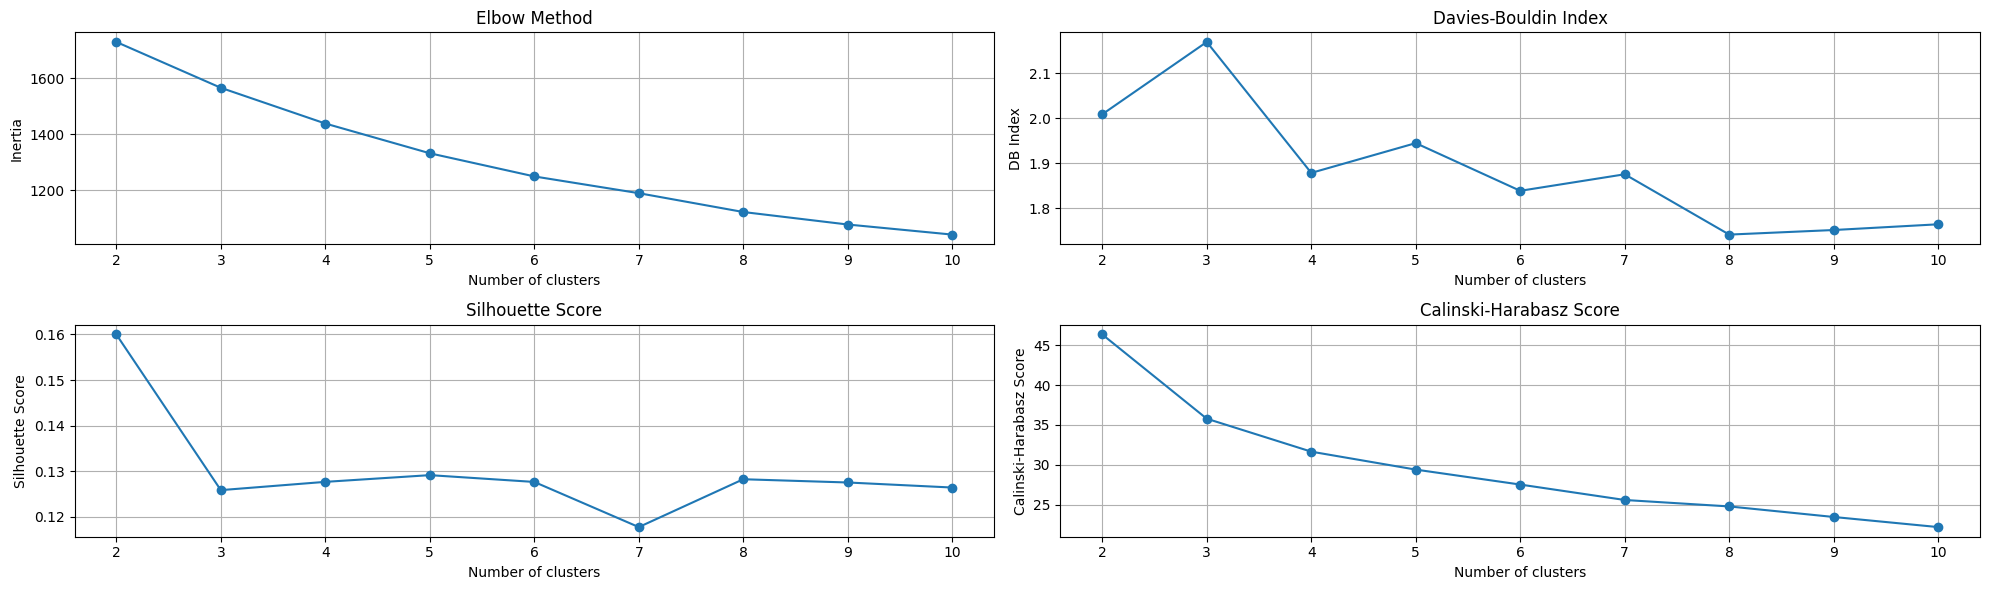

In [15]:
# Plotting the Elbow Method and DB Index scores in the same row
fig, axes = plt.subplots(2, 2, figsize=(20, 6))

# Elbow Method
axes[0, 0].plot(range(2, 11), inertia, marker='o')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].set_xlabel('Number of clusters')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(True)

# DB Index
axes[0, 1].plot(range(2, 11), db_scores, marker='o')
axes[0, 1].set_title('Davies-Bouldin Index')
axes[0, 1].set_xlabel('Number of clusters')
axes[0, 1].set_ylabel('DB Index')
axes[0, 1].grid(True)

# Silhouette Score
axes[1, 0].plot(range(2, 11), silhouette_scores, marker='o')
axes[1, 0].set_title('Silhouette Score')
axes[1, 0].set_xlabel('Number of clusters')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].grid(True)

# Calinski-Harabasz Score
axes[1, 1].plot(range(2, 11), calinski_harabasz_scores, marker='o')
axes[1, 1].set_title('Calinski-Harabasz Score')
axes[1, 1].set_xlabel('Number of clusters')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## Perform K-Means Clustering

In [16]:
# Choose the number of clusters (k) based on the plots and analysis
chosen_k = 6

kmeans = KMeans(n_clusters=chosen_k, random_state=0, n_init=10)
customers['Cluster'] = kmeans.fit_predict(clustering_data)

# Cluster Evaluation and Visualization

## Metrics for Cluster Evaluation

In [20]:
db_index = davies_bouldin_score(clustering_data, customers['Cluster'])
print(f"Davies-Bouldin Index for k={chosen_k}: {db_index}")

silhouette = silhouette_score(clustering_data, customers['Cluster'])
print(f"Silhouette Score for k={chosen_k}: {silhouette}")

calinski_harabasz = calinski_harabasz_score(clustering_data, customers['Cluster'])
print(f"Calinski-Harabasz Score for k={chosen_k}: {calinski_harabasz}")

Davies-Bouldin Index for k=6: 1.8392353682316722
Silhouette Score for k=6: 0.12766301976648628
Calinski-Harabasz Score for k=6: 27.5254260358545


## Cluster Visualization

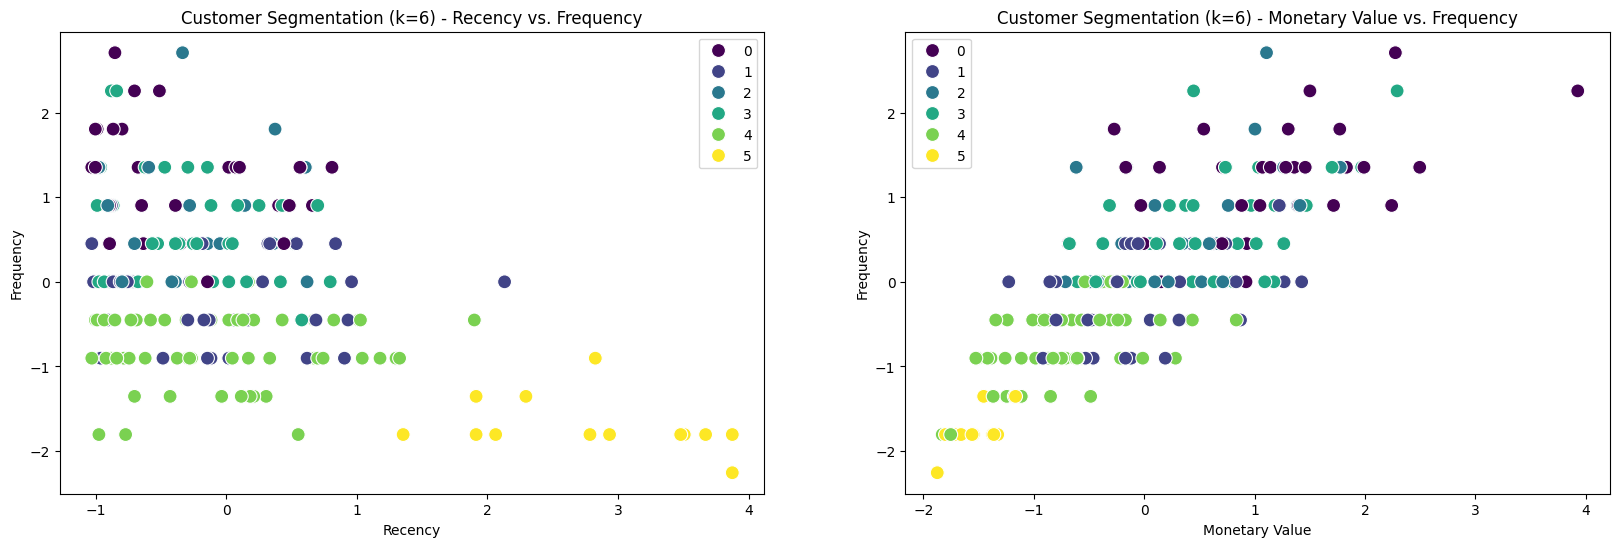

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Scatter plot of Recency vs. Frequency, colored by cluster
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=customers, palette='viridis', s=100, ax=axes[0])
axes[0].set_title(f'Customer Segmentation (k={chosen_k}) - Recency vs. Frequency')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Scatter plot of MonetaryValue vs. Frequency, colored by cluster
sns.scatterplot(x='MonetaryValue', y='Frequency', hue='Cluster', data=customers, palette='viridis', s=100, ax=axes[1])
axes[1].set_title(f'Customer Segmentation (k={chosen_k}) - Monetary Value vs. Frequency')
axes[1].set_xlabel('Monetary Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.show()


## Cluster Profiling

In [19]:
cluster_means = customers.groupby('Cluster')[features_for_clustering].mean()
cluster_means

,Recency,Frequency,MonetaryValue,SignupYear,SignupMonth,Category_Books,Category_Clothing,Category_Electronics,Category_Home Decor,Region_Asia,Region_Europe,Region_North America,Region_South America
Cluster,,,,,,,,,,,,,
0,-0.374075,1.193745,1.103824,-0.548650,-0.222385,2.870968,1.612903,2.290323,0.870968,0.290323,0.161290,0.129032,0.419355
1,-0.133635,-0.154390,-0.006544,0.535849,0.707138,1.026316,0.578947,2.105263,0.947368,0.105263,0.342105,0.263158,0.289474
2,-0.360894,0.620529,0.382547,0.306720,-0.448094,1.083333,2.958333,1.416667,0.916667,0.375000,0.041667,0.375000,0.208333
3,-0.248032,0.606023,0.515833,0.250182,-0.138639,1.657143,0.742857,1.028571,2.914286,0.114286,0.257143,0.285714,0.342857
4,-0.042065,-0.764905,-0.708749,-0.411029,-0.113435,0.949153,0.932203,0.525424,0.898305,0.237288,0.338983,0.152542,0.271186
5,2.807606,-1.701030,-1.491459,0.367608,0.178611,0.153846,0.307692,0.153846,0.615385,0.384615,0.153846,0.307692,0.153846
